### Install necessasy libraries

In [26]:
import networkx as nx
!pip install node2vec
from node2vec import Node2Vec
import networkx as nx
import gensim 
import numpy as np
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt 
plt.style.use('default')

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import random

### 1.  Random walk on graphs

Implements a random walk sampling from a target node in graphs

In [27]:
#list of node
V = ['A', 'B', 'C', 'D','E', 'F', 'G', 'H', 'I', 'J', 'K']

In [28]:
#list of Edges
E =  [('A', 'B'), ('A', 'C'), ('B', 'D'), ('B', 'F'), ('C', 'D'), ('D', 'E'), ('D', 'H'), ('D', 'G'),('G', 'H'),
      ('E', 'F'),('E', 'H'), ('F', 'I'), ('I', 'H'), ('I', 'J'), ('H', 'K')]

In [29]:
G = nx.Graph()

In [30]:
#add nodes to graph g

G.add_nodes_from(V)
G.add_edges_from(E)

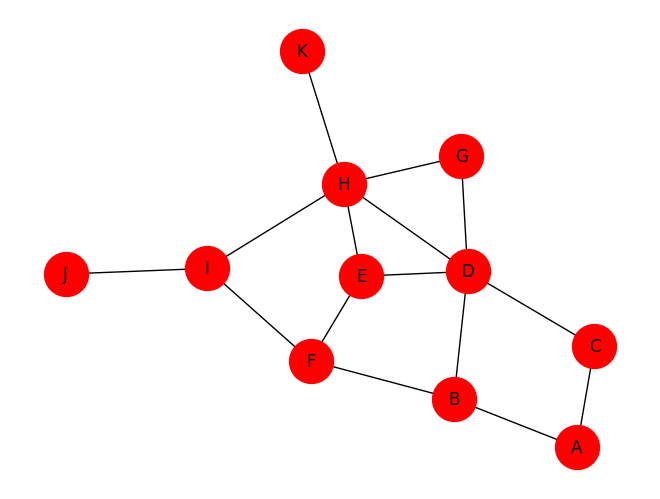

In [31]:
nx.draw(G, with_labels=True,node_color='red', node_size=1000)

In [32]:
# Get random walk sentence from a node

# Input: 
# G: graph
# node: target node
# walk_length: length of walk
def random_walk(Graph, node, walk_length):
    rwalk= [node]
    for i in range(walk_length-1):
        temp= list(Graph.neighbors(node))
        temp = list(set(temp) - set(rwalk))
        if temp == 0:
            break
        new_node = random.choice(temp)
        rwalk.append(new_node)
        node = new_node
    return rwalk

#### Testing random walk from node A: Starting random walk from A

In [33]:
random_walk(G, 'A', 6)

['A', 'C', 'D', 'E', 'F', 'B']

### 2. DeepWalk and Node2Vec model

In [34]:
#Install libraries

import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
import gensim
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [35]:
!pip install word2vec
!pip install node2vec

  Using cached word2vec-0.11.1.tar.gz (42 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build word2vec


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [130 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib
  creating build\lib\word2vec
  copying word2vec\io.py -> build\lib\word2vec
  copying word2vec\scripts_interface.py -> build\lib\word2vec
  copying word2vec\utils.py -> build\lib\word2vec
  copying word2vec\wordclusters.py -> build\lib\word2vec
  copying word2vec\wordvectors.py -> build\lib\word2vec
  copying word2vec\_generated_version.py -> build\lib\word2vec
  copying word2vec\__init__.py -> build\lib\word2vec
  creating build\lib\word2vec\tests
  copying word2vec\tests\test_core.py -> build\lib\word2vec\tests
  copying word2vec\tests\test_import.py -> build\lib\word2vec\tests
  copying word2vec\tests\test_scripts_present.py -> build\lib\word2vec\tests
  copying word2vec\tests\__init__.py -> build\lib\word2vec\tests
  running egg_info
  writing word2vec.egg-info\PKG-INFO
  writing dependency_links to word2v

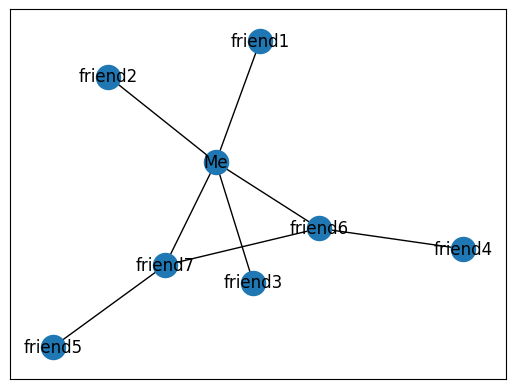

In [36]:
#Construct a graph with 8 nodes
node_list=['friend1','friend2','friend3','Me','friend6','friend7','friend4','friend5']
edge_list=[('friend1','Me',1),('friend2','Me',1),('friend3','Me',1),('friend6','Me',1),
           ('friend7','Me',1),('friend4','friend6',1),('friend5','friend7',1),('friend6','friend7',1)]
G=nx.Graph()

G.add_nodes_from(node_list)
G.add_weighted_edges_from(edge_list)
#plot
nx.draw_networkx(G)

#### Checking the edge existence

In [37]:
G.edges(data=True)
G.has_edge('friend1','Me')

True

#### 2.1. Deepwalk

In [38]:
import random
random.seed(666)
def random_walk(G,start=None,path_length=20,alpha=0,rand=random.Random()):
    '''return a random walk path'''
    if start:
        path=[start]
    else:
        path=[rand.choice(list(G.nodes()))]
    while len(path)<path_length:
        cur=path[-1]
        #find it's neighbors
        if len(G[cur])>0:
            if rand.random()>=alpha:
                path.append(rand.choice(list(nx.all_neighbors(G,cur))))
            else:
                path.append(path[0])
        else:
            break
    return path
print(random_walk(G,start='Me'))
            

['Me', 'friend1', 'Me', 'friend2', 'Me', 'friend2', 'Me', 'friend7', 'Me', 'friend2', 'Me', 'friend2', 'Me', 'friend7', 'friend6', 'friend7', 'friend5', 'friend7', 'friend5', 'friend7']


In [39]:
def build_deepwalk_corpus(G,num_paths,rand=random.Random()):
    walks=[]
    nodes=list(G.nodes())
    for i in range(num_paths):
        rand.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(G,start=node))
    return walks
print(build_deepwalk_corpus(G,num_paths=2))

[['friend2', 'Me', 'friend3', 'Me', 'friend2', 'Me', 'friend7', 'friend6', 'friend4', 'friend6', 'friend7', 'friend5', 'friend7', 'Me', 'friend3', 'Me', 'friend6', 'Me', 'friend1', 'Me'], ['friend5', 'friend7', 'Me', 'friend3', 'Me', 'friend7', 'friend6', 'Me', 'friend7', 'friend6', 'friend4', 'friend6', 'friend7', 'friend6', 'Me', 'friend2', 'Me', 'friend3', 'Me', 'friend1'], ['Me', 'friend6', 'Me', 'friend2', 'Me', 'friend1', 'Me', 'friend7', 'Me', 'friend6', 'Me', 'friend7', 'friend6', 'Me', 'friend2', 'Me', 'friend7', 'friend5', 'friend7', 'Me'], ['friend4', 'friend6', 'friend4', 'friend6', 'friend7', 'friend5', 'friend7', 'friend5', 'friend7', 'friend6', 'Me', 'friend7', 'friend6', 'friend7', 'Me', 'friend7', 'friend6', 'friend7', 'friend5', 'friend7'], ['friend7', 'friend5', 'friend7', 'friend6', 'Me', 'friend3', 'Me', 'friend6', 'friend4', 'friend6', 'Me', 'friend6', 'friend7', 'friend5', 'friend7', 'friend6', 'friend7', 'friend5', 'friend7', 'friend5'], ['friend3', 'Me', 'frien

In [40]:
from gensim.models import Word2Vec
corpus=build_deepwalk_corpus(G,num_paths=20)
model=Word2Vec(corpus,vector_size=20,window=2,min_count=1,sg=1)
model.wv['Me']
model.wv.most_similar('friend4')

[('Me', 0.989459216594696),
 ('friend6', 0.9869422316551208),
 ('friend1', 0.9858598113059998),
 ('friend3', 0.9857534170150757),
 ('friend7', 0.9843538999557495),
 ('friend2', 0.9824880957603455),
 ('friend5', 0.9824351668357849)]

In [41]:
model.wv.most_similar('Me',topn=3)

[('friend4', 0.9894593358039856),
 ('friend2', 0.9890974760055542),
 ('friend1', 0.9882360696792603)]

#### 2.2. Node2Vec

In [42]:
#Create alias table by alias sample

import numpy as np
def create_alias_table(area_ratio):
    '''
    area_ratio[i] current node
    '''
    N=len(area_ratio)
    accept,alias=[0]*N,[0]*N
    small,large=[],[]
    area_ratio=np.array(area_ratio)*N
    for i,prob in enumerate(area_ratio):
        if prob<1:
            small.append(i)
        else:
            large.append(i)
    while large and small:
        small_idx,large_idx=small.pop(),large.pop()
        accept[small_idx]=area_ratio[small_idx]
        alias[small_idx]=large_idx
        area_ratio[large_idx]=area_ratio[large_idx]-(1-alias[small_idx])
        if area_ratio[large_idx]<1:
            small.append(large_idx)
        else:
            large.append(large_idx)
            
    while large:
        large_idx=large.pop()
        accept[large_idx]=1
    while small:
        small_idx=small.pop()
        accept[small_idx]=1
    
    return accept,alias
        

In [43]:
def alias_sample(accept,alias):
    N=len(accept)
    i=int(np.floor(np.random.rand()*N))
    r=np.random.rand()
    if r<accept[i]:
        return i
    else:
        return alias[i]

In [44]:
G.get_edge_data('Me','friend6')
list(G.nodes())
list(G.edges())
G.has_edge('friend6','Me')
sorted(G.neighbors('Me'))

['friend1', 'friend2', 'friend3', 'friend6', 'friend7']

In [45]:
def get_alias_edge(G,t,v,p,q):
    '''t:previous node v:current node'''
    unnormalized_probs=[]
    for x in sorted(G.neighbors(v)):
        weight=G.get_edge_data(x,v)['weight']
        if x==t:  #go back
            unnormalized_probs.append(weight/p)
        elif G.has_edge(x,t): #BFS
            unnormalized_probs.append(weight)
        else: #DFS
            unnormalized_probs.append(weight/q)
    norm=sum(unnormalized_probs)
    normalized_probs=list(map(lambda x:x/norm,unnormalized_probs))
    return create_alias_table(normalized_probs)
    

In [51]:
def preprocess_transition_probs(G,p,q):
    alias_nodes={}
    for node in sorted(G.nodes()):
        unnormalized_probs=[G.get_edge_data(node,nbr)['weight'] for nbr in sorted(G.neighbors(node))]
        norm=sum(unnormalized_probs)
        normalized_probs=list(map(lambda x:x/norm,unnormalized_probs))
        alias_nodes[node]=create_alias_table(normalized_probs)
    alias_edges={}
    for edge in list(G.edges()):
        alias_edges[edge]=get_alias_edge(G,edge[0],edge[1],p,q)
        alias_edges[(edge[1],edge[0])]=get_alias_edge(G,edge[1],edge[0],p,q)
    return alias_nodes,alias_edges

alias_nodes,alias_edges=preprocess_transition_probs(G,2,0.8)
alias_nodes

{'Me': ([1, 1, 1, 1, 1], [0, 0, 0, 0, 0]),
 'friend1': ([1], [0]),
 'friend2': ([1], [0]),
 'friend3': ([1], [0]),
 'friend4': ([1], [0]),
 'friend5': ([1], [0]),
 'friend6': ([1, 1, 1], [0, 0, 0]),
 'friend7': ([1, 1, 1], [0, 0, 0])}

In [52]:
def node2vec_walk(G,walk_length,start_node,alias_nodes,alias_edges):
    walk=[start_node]
    while len(walk)<walk_length:
        cur=walk[-1]
        cur_nbrs=sorted(G.neighbors(cur))
        if len(cur_nbrs)>0:
            if len(walk)==1:
                walk.append(cur_nbrs[alias_sample(alias_nodes[cur][0],alias_nodes[cur][1])])
            else:
                prev=walk[-2]
                next=cur_nbrs[alias_sample(alias_edges[(prev,cur)][0],alias_edges[(prev,cur)][1])]
                walk.append(next)
        else:
            break
    return walk

In [53]:
node2vec_walk(G,10,'Me',alias_nodes,alias_edges)

['Me',
 'friend1',
 'Me',
 'friend7',
 'friend5',
 'friend7',
 'friend6',
 'friend4',
 'friend6',
 'Me']

In [54]:
import random
def simulate_walks(G,num_walks,walk_length,alias_nodes,alias_edges,rand=random.Random()):
    walks=[]
    nodes=list(G.nodes())
    for i in range(num_walks):
        rand.shuffle(nodes)
        for node in nodes:
            walks.append(node2vec_walk(G,walk_length,node,alias_nodes,alias_edges))
    return walks
    

In [55]:
walks=simulate_walks(G,10,10,alias_nodes,alias_edges,rand=random.Random())


In [56]:
from gensim.models import Word2Vec
model = Word2Vec(walks, vector_size=20, window=2, min_count=0, sg=1)
model.wv['friend6']

array([-0.05097576,  0.02900556, -0.04111341, -0.01788727, -0.00489963,
       -0.00634323, -0.03578704,  0.06324959,  0.0189546 ,  0.04888568,
       -0.03733796,  0.02167176, -0.02338812,  0.00549331,  0.04667556,
       -0.0219806 ,  0.03338924, -0.03715036, -0.02555178,  0.04464331],
      dtype=float32)

In [57]:
model.wv.most_similar('Me',topn=3)


[('friend3', 0.4719013273715973),
 ('friend5', 0.2425147145986557),
 ('friend7', 0.22787274420261383)]

#### 3 LINE model 

In [58]:
class AliasSampling:
    def __init__(self,area_ratio):
        self.area_ratio=area_ratio
        self.accept,self.alias=self.create_alias_table()
        self.alias_sample()
    def create_alias_table(self):
        N=len(self.area_ratio)
        accept,alias=[0]*N,[0]*N
        small,large=[],[]
        area_ratio=np.array(self.area_ratio)*N
        for i,prob in enumerate(area_ratio):
            if prob<1:
                small.append(i)
            else:
                large.append(i)
        while large and small:
            small_idx,large_idx=small.pop(),large.pop()
            accept[small_idx]=area_ratio[small_idx]
            alias[small_idx]=large_idx
            area_ratio[large_idx]=area_ratio[large_idx]-(1-alias[small_idx])
            if area_ratio[large_idx]<1:
                small.append(large_idx)
            else:
                large.append(large_idx)
            
        while large:
            large_idx=large.pop()
            accept[large_idx]=1
        while small:
            small_idx=small.pop()
            accept[small_idx]=1
        return accept,alias
    
    def alias_sample(self):
        N=len(self.accept)
        i=int(np.floor(np.random.rand()*N))
        r=np.random.rand()
        if r<self.accept[i]:
            return i
        else:
            return self.alias[i]

In [59]:
class DataLoader:
    def __init__(self,G):
        self.g=G
        self.num_of_nodes=self.g.number_of_nodes()
        self.num_of_edges=self.g.number_of_edges()
        self.edges_raw=list(self.g.edges(data=True))
        self.nodes_raw=list(self.g.nodes())
        self.edge_distribution=np.array([attr['weight'] for _,_,attr in self.edges_raw],dtype=np.float32)
        self.edge_distribution/=np.sum(self.edge_distribution)
        self.node_negative_distribution=np.power(np.array([self.g.degree(node) for node in self.nodes_raw],dtype=np.float32),0.75)
        self.node_negative_distribution/=np.sum(self.node_negative_distribution)
        # create node table
        self.node2idx={}
        self.idx2node={}
        for idx,node in enumerate(self.nodes_raw):
            self.node2idx[node]=idx
            self.idx2node[idx]=node
        self.edges=[(self.node2idx[u],self.node2idx[v]) for u,v,_ in self.edges_raw]
        
    def fetch_batch(self,batch_size=5,K=3):
        edge_batch_idx=np.random.choice(self.num_of_edges,size=batch_size,p=self.edge_distribution)
        #print(edge_batch_idx)
        u_i=[]
        u_j=[]
        label=[]
        for edge_idx in edge_batch_idx:
            edge=self.edges[edge_idx]
           
            if np.random.rand()>0.5:
                edge=(edge[1],edge[0])
            u_i.append(edge[0])
            u_j.append(edge[1])
            label.append(1)
            #进入负采样
            for i in range(K):
                while True:
                    negative_node=np.random.choice(self.num_of_nodes,p=self.node_negative_distribution)
                    #If the sampling is not connected, the rich sampling successfully exits the while true loop,
                    #and then negative sampling.
                    if not self.g.has_edge(self.idx2node[edge[0]],self.idx2node[negative_node]):
                        break
                u_i.append(edge[0])
                u_j.append(negative_node)
                label.append(-1)
        return u_i,u_j,label
        
    def embedding_mapping(self,embedding):
        return {node:embedding[self.node2idx[node]] for node in self.nodes_raw}

In [60]:
!pip install tensorflow
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

class LINE:
    def __init__(self,args):
        self.u_i=tf.placeholder(dtype=tf.int32,shape=[args.batch_size*(args.K+1)],name='u_i')
        self.u_j=tf.placeholder(dtype=tf.int32,shape=[args.batch_size*(args.K+1)],name='u_j')
        self.label=tf.placeholder(dtype=tf.float32,shape=[args.batch_size*(args.K+1)],name='label')
        with tf.variable_scope('embedding',reuse=tf.AUTO_REUSE):
            self.embedding=tf.Variable(tf.truncated_normal([args.num_of_nodes,args.embedding_dim]))
        #self.embedding=tf.get_variable(shape=[args.num_of_nodes,args.embedding_dim],initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
         #                              name='embedding')
        self.u_i_embedding=tf.nn.embedding_lookup(self.embedding,self.u_i)
        if args.proximity=='first-order':
            self.u_j_embedding=tf.nn.embedding_lookup(self.embedding,self.u_j)
        elif args.proximity=='second-order':
            with tf.variable_scope('context_embedding',reuse=tf.AUTO_REUSE):
                self.context_embedding=tf.Variable(tf.truncated_normal([args.num_of_nodes,args.embedding_dim]))
            #self.context_embedding=tf.get_variable(shape=[args.num_of_nodes,args.embedding_dim],initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
              #                                    name='context_embedding')
            self.u_j_embedding=tf.nn.embedding_lookup(self.context_embedding,self.u_j)
        self.inner_product=tf.reduce_sum(self.u_i_embedding*self.u_j_embedding,axis=1)
        self.loss=-tf.reduce_mean(tf.log_sigmoid(self.label*self.inner_product))
        self.learning_rate=tf.placeholder(dtype=tf.float32,name='learning_rate')
        self.optimizer=tf.train.RMSPropOptimizer(learning_rate=self.learning_rate)
        self.train_op=self.optimizer.minimize(self.loss)
        

Instructions for updating:
non-resource variables are not supported in the long term


In [61]:
from argparse import Namespace

        
def train(args):
    data_loader=DataLoader(G)
    suffix=args.proximity
    args.num_of_nodes=data_loader.num_of_nodes
    model=LINE(args)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        initial_embedding=sess.run(model.embedding)
        learning_rate=args.learning_rate
        #u_i,u_j,label=data_loader.fetch_batch(batch_size=args.batch_size,K=args.K)
        #print(len(u_i))
        for i in range(args.num_batches):
            u_i,u_j,label=data_loader.fetch_batch(batch_size=args.batch_size,K=args.K)
            feed_dict={model.u_i:u_i,model.u_j:u_j,model.label:label,model.learning_rate:learning_rate}
            loss,_=sess.run([model.loss,model.train_op],feed_dict=feed_dict)
            #print(i,loss)
        if i==args.num_batches-1:
            embedding=sess.run(model.embedding)
            normalized_embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
            return data_loader.embedding_mapping(normalized_embedding)
if __name__=='__main__':
    args=Namespace()
    args.proximity='first-order'
    args.embedding_dim=20
    args.num_batches=100
    args.K=3
    args.batch_size=5
    args.learning_rate=0.001
    embedding_dict=train(args)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [62]:
def cos_similarity(a,b):
    a=np.mat(a)
    b=np.mat(b)
    num = float(a * b.T)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim
    

In [63]:
embedding_dict['Me']
cos_similarity(embedding_dict['friend6'],embedding_dict['friend7'])

0.5352724811597157

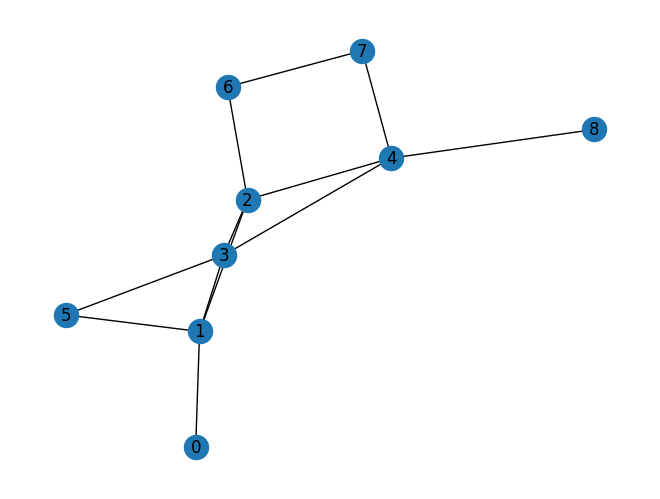

In [64]:
# Filling labels for graph G
import networkx as nx
def fill_labels(G):
    for i in range(len(G.nodes)):
        G.nodes[i]['label'] = '1'
G = nx.Graph([
    (0, 1),
    (1 ,2), 
    (1 ,3),
    (1 ,5),
    (2 ,3),
    (2 ,4),
    (2 ,6),
    (3 ,4),
    (3 ,5),
    (4 ,7),
    (4 ,8),
    (6 ,7)])
fill_labels(G)
nx.draw(G, with_labels = True)

### 4. Subgraph WL relabeling 

In [65]:
# Weisfeiler-Lehman (WL) relabeling subraph in G:
def wlk_relabel(g,h):
    '''
    Perform node relabeling (coloring) according 1-d WL relabeling process (refer Shervashidze et al (2009) paper)
    :param g: networkx graph
    :param h: height of WL kernel
    :return: relabeled graph
    '''
    for i in range(len(g.nodes)):
        g.nodes[i]['relabel'] = {}
        
    for i in range(0,h+1): #xrange returns [min,max)
        for n in range(len(g.nodes)):
            # degree_prefix = 'D' + str(i)
            degree_prefix = ''
            if 0 == i:
                g.nodes[n]['relabel'][0] = degree_prefix + str(g.nodes[n]['label']).strip() + degree_prefix
            else:
                nei_labels = [g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g,n)]
                nei_labels.sort()
                sorted_nei_labels = (','*i).join(nei_labels)

                current_in_relabel = g.nodes[n]['relabel'][i-1] +'#'*i+ sorted_nei_labels
                g.nodes[n]['relabel'][i] = degree_prefix + current_in_relabel.strip() + degree_prefix
    return g #relabled graph

In [66]:
G = wlk_relabel(G,1)

In [67]:
def draw_graph(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['relabel']
        print(f'Node ID {n}: colour: {c}')
        col = 0
        if c=='1':
            clubs.append('green')
        elif c =='2':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph

Node ID 0: colour: {0: '1', 1: '1#1'}
Node ID 1: colour: {0: '1', 1: '1#1,1,1,1'}
Node ID 2: colour: {0: '1', 1: '1#1,1,1,1'}
Node ID 3: colour: {0: '1', 1: '1#1,1,1,1'}
Node ID 5: colour: {0: '1', 1: '1#1,1'}
Node ID 4: colour: {0: '1', 1: '1#1,1,1,1'}
Node ID 6: colour: {0: '1', 1: '1#1,1'}
Node ID 7: colour: {0: '1', 1: '1#1,1'}
Node ID 8: colour: {0: '1', 1: '1#1'}


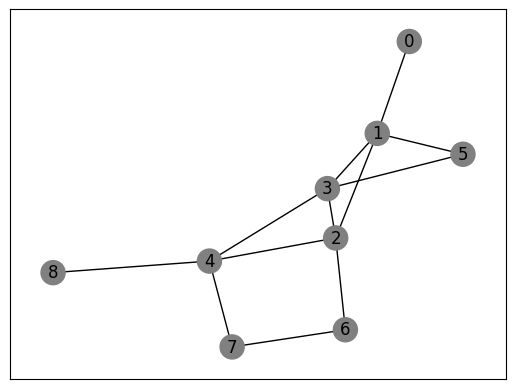

In [68]:
#nx.draw(G, with_labels = True)
draw_graph(G)

In [69]:
def get_graph_as_bow (g, h):
    for n, d in list(g.nodes(data=True)):
        for i in range(0, h+1):
            center = d['relabel'][i]
            neis_labels_prev_deg = []
            neis_labels_next_deg = []

            if -1 != i-1:
                neis_labels_prev_deg = [g.nodes[nei]['relabel'][i-1] for nei in nx.all_neighbors(g, n)] + [d['relabel'][i-1]]
            NeisLabelsSameDeg = [g.nodes[nei]['relabel'][i] for nei in nx.all_neighbors(g,n)]
            if not i+1 > h:
                neis_labels_next_deg = [g.nodes[nei]['relabel'][i+1] for nei in nx.all_neighbors(g,n)] + [d['relabel'][i+1]]


            nei_list = NeisLabelsSameDeg + neis_labels_prev_deg + neis_labels_next_deg
            try:
                nei_list.append(d['relabel'][i-1]) #prev degree subgraph from the current node
            except:
                pass
            try:
                nei_list.append(d['relabel'][i+1]) #next degree subgraph from the current node
            except:
                pass

            nei_list = ' '.join (nei_list)

            sentence = center + ' ' + nei_list
            print( sentence)
            yield sentence

In [70]:
subgraph2vec_sentences = get_graph_as_bow(G, 1)

#### Get all subgraph sentences

In [71]:
for w in subgraph2vec_sentences:
    print(w)

1 1 1#1,1,1,1 1#1 1#1
1 1 1#1,1,1,1 1#1 1#1
1#1 1#1,1,1,1 1 1 1
1#1 1#1,1,1,1 1 1 1
1 1 1 1 1 1#1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1 1 1 1 1 1#1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1#1,1,1,1 1#1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1#1,1,1,1 1#1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1 1 1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1 1 1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1 1 1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1 1 1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1,1,1 1#1,1,1,1
1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1,1,1 1#1,1 1 1 1 1 1 1
1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1
1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1,1
1#1,1 1#1,1,1,1 1#1,1,1,1 1 1 1 1
1#1,1 1#1,1,1,1 1#1,1,1,1 1 1 1 1
1 1 1 1 1 1#1,1,1,1 1#1,1,1,1 1#1,1 1#1 1#1,1,1,1 1#